In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers import *

set_seed(99, True)

In [7]:
bs = 128

vision_arch = 'resnet18'
# vision_arch = 'levit_256'
# vision_arch = 'levit_384'

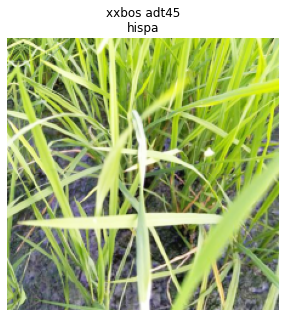

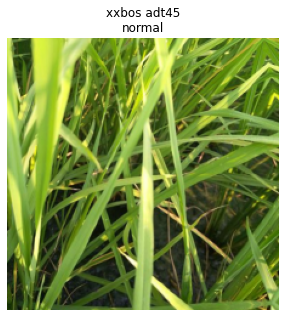

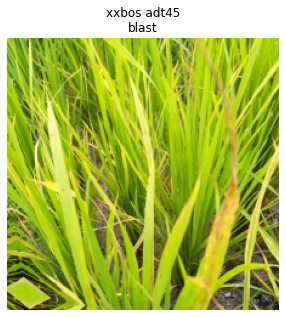

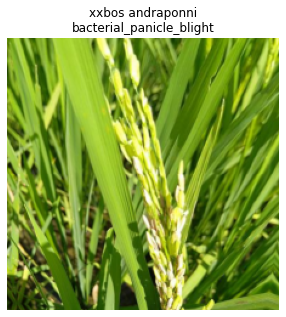

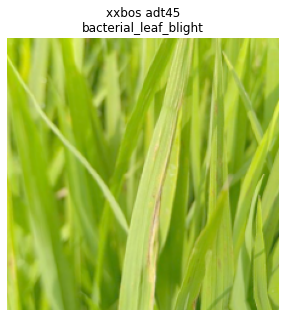

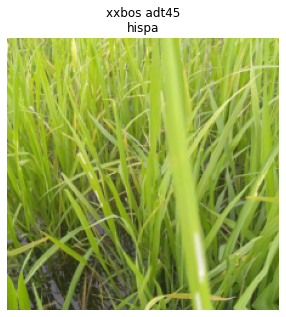

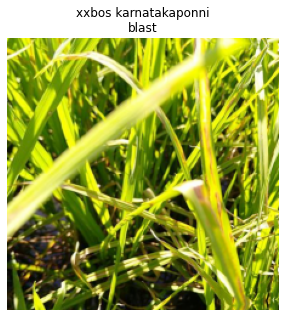

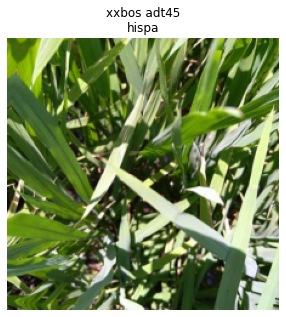

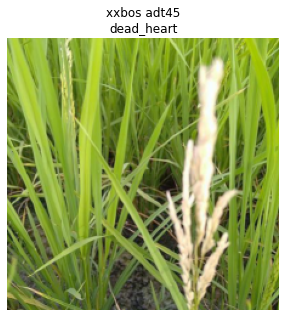

In [8]:
dls = get_image_and_text_dls(bs)
dls.show_batch()

# Multi Modal Model

In [21]:
class MyMultiModalModel(Module):
    def __init__(self, text_weight: float = 0.5):
        self.text_weight = text_weight
        self.vision = vision_learner(dls, vision_arch, metrics=[accuracy]).model
        self.text = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy], drop_mult=0.2).model
    
    def forward(self, *inputs, **kwargs):
        images, texts = inputs
        v_out = self.vision(images)
        t_out = self.text(texts.type('Long'))[0]
        return ((v_out * (1 - self.text_weight)) + (t_out * self.text_weight))

In [7]:
learn = Learner(dls, MyMultiModalModel(text_weight=0.5), metrics=[accuracy], cbs=[ShowGraphCallback()])

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# learn.lr_find(suggest_funcs=(steep, valley))

In [9]:
lr = 2e-2

epoch,train_loss,valid_loss,accuracy,time
0,1.759925,1.380750,0.630947,00:25
1,1.508129,1.172937,0.664584,00:23
2,1.453592,1.185883,0.671312,00:23
3,1.370710,1.082752,0.705911,00:23
4,1.204997,0.792719,0.748679,00:24
5,1.069598,0.729266,0.777030,00:23
6,0.988083,0.695889,0.791446,00:23
7,0.898243,0.647678,0.805382,00:23
8,0.846372,0.613813,0.817876,00:23
9,0.830268,0.638250,0.814032,00:23


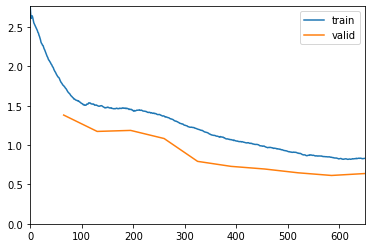

In [10]:
learn.fit_one_cycle(10, lr)

# Find good text_weight

Text Weight: 0.000


/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Steep: 0.019054606556892395; Valley: 0.0012022644514217973; lr: 0.019054606556892395


epoch,train_loss,valid_loss,accuracy,time
0,2.086072,1.363069,0.636713,00:23
1,1.733910,1.368454,0.631427,00:24
2,1.662943,1.335644,0.690053,00:24
3,1.581259,1.205405,0.675637,00:24
4,1.431299,0.959207,0.714080,00:24
5,1.245939,0.885367,0.736185,00:24
6,1.105305,0.764527,0.758289,00:24
7,1.006584,0.710568,0.784719,00:24
8,0.932947,0.681295,0.796252,00:24
9,0.895287,0.652315,0.802979,00:24


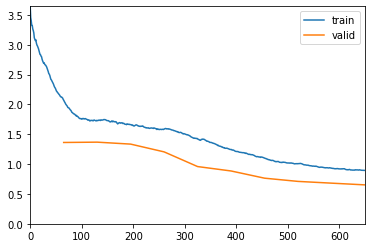

Text Weight: 0.100


Steep: 0.007585775572806597; Valley: 0.0020892962347716093; lr: 0.007585775572806597


epoch,train_loss,valid_loss,accuracy,time
0,2.301078,1.463930,0.600192,00:24
1,1.717084,1.644482,0.652090,00:24
2,1.460613,1.205596,0.702066,00:31
3,1.289821,0.901810,0.740990,00:24
4,1.160339,0.936089,0.767420,00:23
5,1.049495,0.833800,0.790005,00:24
6,0.925802,0.776086,0.805382,00:24
7,0.841835,0.705998,0.810668,00:24
8,0.802778,0.639628,0.827006,00:24
9,0.778269,0.526048,0.836617,00:24


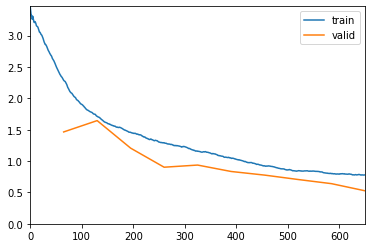

Text Weight: 0.200


Steep: 0.02290867641568184; Valley: 0.0014454397605732083; lr: 0.02290867641568184


epoch,train_loss,valid_loss,accuracy,time
0,1.930994,1.421233,0.629986,00:23
1,1.665840,1.265010,0.623739,00:24
2,1.598092,1.369553,0.614128,00:24
3,1.551531,1.194088,0.637674,00:24
4,1.434537,1.048365,0.693417,00:24
5,1.348127,1.116620,0.647766,00:24
6,1.288551,0.996530,0.681403,00:24
7,1.182591,0.889734,0.715521,00:24
8,1.090877,0.870583,0.729457,00:23
9,1.068587,0.848102,0.737146,00:24


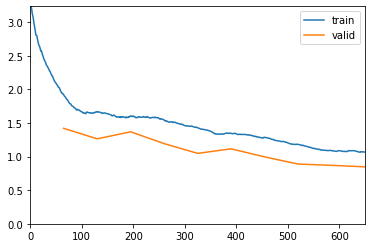

Text Weight: 0.300


Steep: 0.0063095735386013985; Valley: 0.002511886414140463; lr: 0.0063095735386013985


epoch,train_loss,valid_loss,accuracy,time
0,2.200777,1.470206,0.552619,00:24
1,1.634600,1.097179,0.675637,00:24
2,1.375149,1.202030,0.712638,00:24
3,1.216992,0.932245,0.762134,00:24
4,1.093651,0.716599,0.791927,00:24
5,0.994020,0.849259,0.806343,00:24
6,0.891407,0.624260,0.804421,00:24
7,0.839975,0.607566,0.827967,00:24
8,0.805197,0.600590,0.835656,00:24
9,0.787436,0.590847,0.835175,00:24


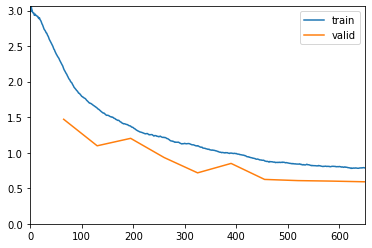

Text Weight: 0.400


Steep: 0.0030199517495930195; Valley: 0.0020892962347716093; lr: 0.0030199517495930195


epoch,train_loss,valid_loss,accuracy,time
0,2.344987,1.704125,0.487266,00:24
1,1.763756,1.138032,0.654974,00:35
2,1.435276,1.092527,0.689572,00:24
3,1.271713,1.007584,0.716482,00:24
4,1.154405,0.886683,0.743873,00:24
5,1.059745,0.833893,0.764536,00:24
6,1.015851,0.800006,0.772705,00:24
7,0.965268,0.685611,0.787602,00:24
8,0.922583,0.754057,0.786641,00:24
9,0.914810,0.729068,0.790966,00:24


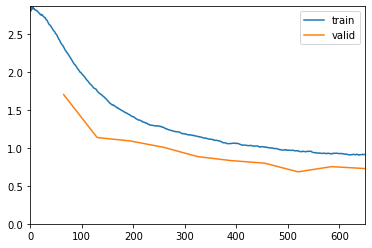

Text Weight: 0.500


Steep: 0.019054606556892395; Valley: 0.0014454397605732083; lr: 0.019054606556892395


epoch,train_loss,valid_loss,accuracy,time
0,1.810015,1.164122,0.642480,00:24
1,1.463718,1.146019,0.613647,00:24
2,1.403346,2.942932,0.589620,00:25
3,1.386794,1.369516,0.637194,00:24
4,1.273851,1.084269,0.707833,00:25
5,1.135948,0.896250,0.716963,00:24
6,1.045639,0.831723,0.740029,00:24
7,0.972742,0.781512,0.776069,00:34
8,0.915597,0.783807,0.772225,00:24
9,0.874525,0.758721,0.781836,00:24


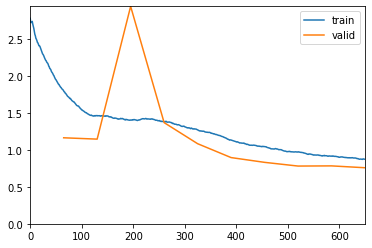

Text Weight: 0.600


Steep: 0.033113110810518265; Valley: 0.00363078061491251; lr: 0.033113110810518265


epoch,train_loss,valid_loss,accuracy,time
0,1.625057,1.639600,0.619894,00:24
1,1.509208,1.555303,0.584815,00:24
2,1.513047,1.413010,0.532917,00:24
3,1.458313,1.149404,0.622778,00:24
4,1.289813,1.018868,0.667468,00:24
5,1.196399,0.904367,0.704950,00:24
6,1.163739,0.955026,0.688611,00:24
7,1.110016,0.877621,0.718405,00:24
8,1.069455,0.857797,0.728015,00:24
9,1.038824,0.838197,0.736665,00:24


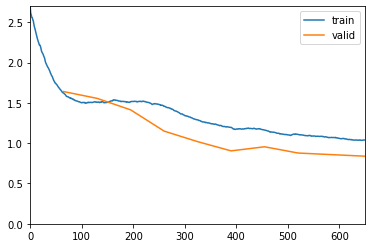

Text Weight: 0.700


Steep: 0.033113110810518265; Valley: 0.0014454397605732083; lr: 0.033113110810518265


epoch,train_loss,valid_loss,accuracy,time
0,1.633362,1.319389,0.636713,00:24
1,1.422730,1.250834,0.637194,00:24
2,1.414300,1.271335,0.593945,00:24
3,1.352859,1.089275,0.641999,00:24
4,1.227638,0.877963,0.729938,00:24
5,1.084919,0.803514,0.744354,00:24
6,1.002213,0.709137,0.777511,00:24
7,0.920682,0.692808,0.775108,00:24
8,0.861958,0.655127,0.790485,00:24
9,0.829462,0.640811,0.798174,00:24


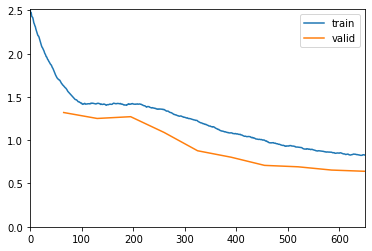

Text Weight: 0.800


Steep: 0.03981071710586548; Valley: 0.002511886414140463; lr: 0.03981071710586548


epoch,train_loss,valid_loss,accuracy,time
0,1.616188,1.125446,0.651610,00:24
1,1.342392,1.058032,0.705430,00:24
2,1.278611,0.935857,0.694858,00:24
3,1.176303,0.911632,0.719366,00:24
4,1.065113,0.738190,0.767420,00:24
5,0.976629,0.723042,0.770303,00:24
6,0.858089,0.585297,0.806824,00:24
7,0.768271,0.556764,0.816915,00:24
8,0.704568,0.521680,0.827967,00:24
9,0.674740,0.528117,0.827006,00:24


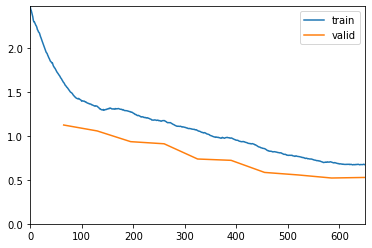

Text Weight: 0.900


Steep: 0.0831763744354248; Valley: 0.00363078061491251; lr: 0.0831763744354248


epoch,train_loss,valid_loss,accuracy,time
0,1.501060,1.454988,0.623258,00:24
1,1.395965,1.375587,0.576165,00:24
2,1.522758,1.357300,0.547814,00:24
3,1.712721,1.636184,0.448823,00:24
4,1.680672,1.445081,0.496396,00:24
5,1.557864,1.315323,0.543489,00:24
6,1.444977,1.209099,0.582412,00:24
7,1.349019,1.097840,0.635752,00:24
8,1.281875,1.050468,0.648727,00:24
9,1.253510,1.050191,0.646324,00:24


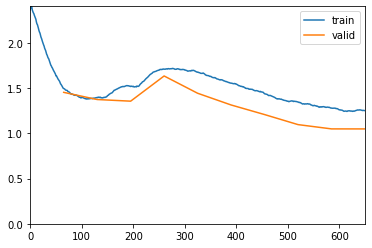

Text Weight: 1.000


Steep: 0.0831763744354248; Valley: 0.0014454397605732083; lr: 0.0831763744354248


epoch,train_loss,valid_loss,accuracy,time
0,2.251612,2.172646,0.115810,00:24
1,2.176115,2.143172,0.181643,00:24
2,2.165704,2.176828,0.181643,00:24
3,2.161144,2.190186,0.172513,00:24
4,2.153527,2.155897,0.174916,00:24
5,2.153773,2.171878,0.174916,00:24
6,2.149207,2.133658,0.174916,00:24
7,2.133602,2.144894,0.174916,00:24
8,2.122731,2.140529,0.174916,00:24
9,2.123521,2.138959,0.174916,00:24


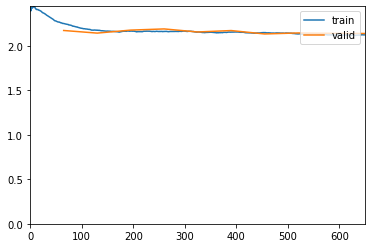

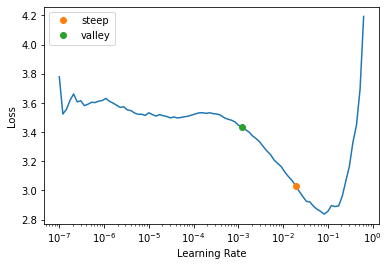

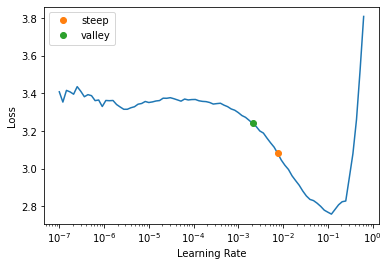

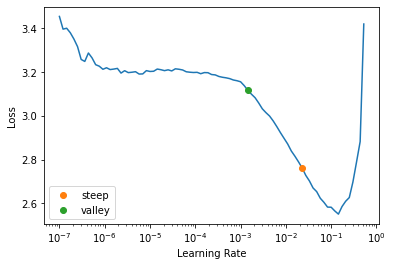

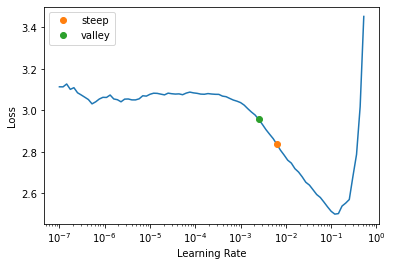

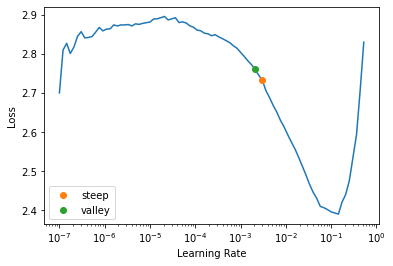

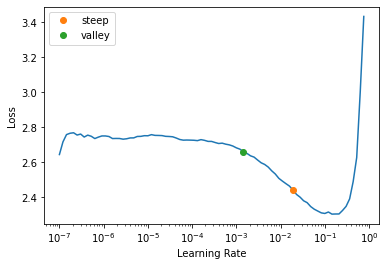

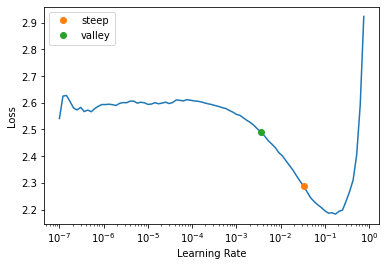

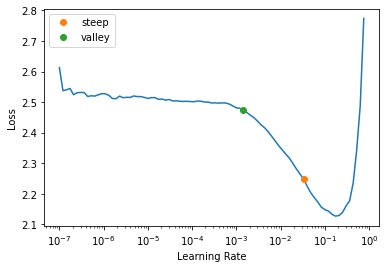

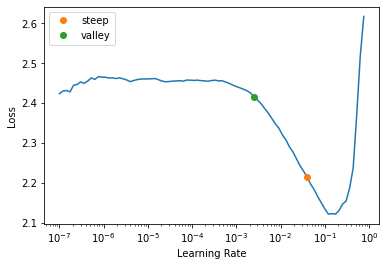

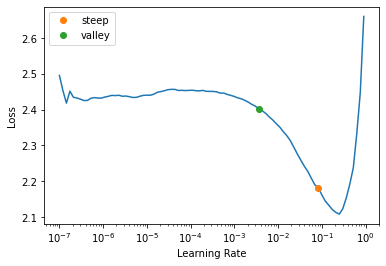

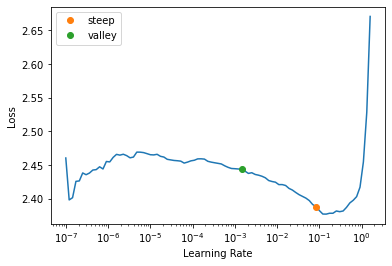

In [10]:
weights = list(np.arange(0, 1.1, 0.1))

for text_weight in weights:
    print(f'Text Weight: {text_weight:.3f}')
    learn = Learner(dls, MyMultiModalModel(text_weight=text_weight), metrics=[accuracy], cbs=[ShowGraphCallback()])

    lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
    lr = lr_steep
    print(f'Steep: {lr_steep}; Valley: {lr_valley}; lr: {lr}')
    
    learn.fit_one_cycle(10, lr)

# Use lr_find with the best weight

epoch,train_loss,valid_loss,accuracy,time
0,2.464184,1.497602,0.558866,00:24
1,1.764028,1.305285,0.691014,00:25
2,1.466061,1.007429,0.706391,00:24
3,1.305271,0.933610,0.736665,00:24
4,1.162691,0.890856,0.763095,00:24
5,1.078253,0.766042,0.777030,00:24
6,0.988196,0.729487,0.814512,00:24
7,0.901219,0.662948,0.817396,00:24
8,0.852060,0.611294,0.832773,00:24
9,0.846555,0.639900,0.825084,00:24


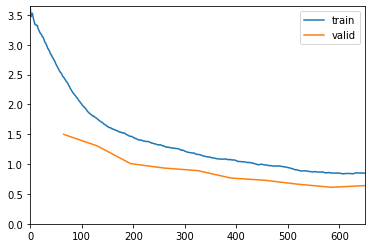

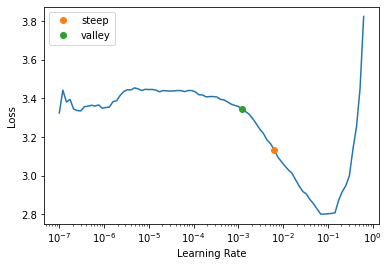

In [11]:
best_text_weight = 0.1

learn = Learner(dls, MyMultiModalModel(best_text_weight), metrics=[accuracy], cbs=[ShowGraphCallback()])
lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
learn.fit_one_cycle(10, lr_steep * 0.8)

# Use larger vision architecture

Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-384-9bdaf2e2.pth" to /root/.cache/torch/hub/checkpoints/LeViT-384-9bdaf2e2.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.621875,1.176058,0.716482,00:31
1,1.506079,1.254572,0.639116,00:32
2,1.406885,1.012090,0.692456,00:32
3,1.177791,1.222008,0.673234,00:32
4,1.100937,0.873196,0.718405,00:32
5,0.945470,0.716119,0.768381,00:32
6,0.833300,0.584631,0.802979,00:32
7,0.737224,0.500221,0.834695,00:32
8,0.658456,0.505470,0.835656,00:32
9,0.612677,0.461161,0.848630,00:32


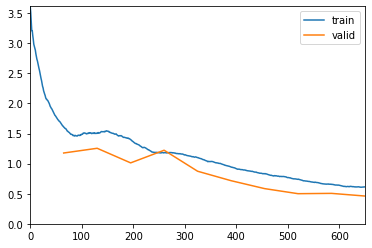

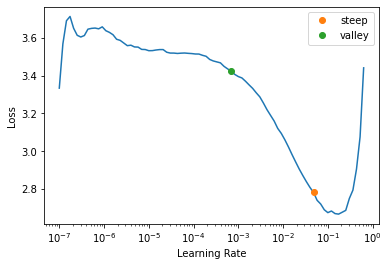

In [12]:
vision_arch = 'levit_384'

learn = Learner(dls, MyMultiModalModel(best_text_weight), metrics=[accuracy], cbs=[ShowGraphCallback()])
lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
learn.fit_one_cycle(10, lr_steep * 0.8)